# Milestone that uses the updated ensemble model to mark superiority over single models.

In [1]:
from pathlib import Path
from typing import Any, Dict, List, Tuple
from dataclasses import dataclass

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

from ml_carbucks import DATA_DIR
from ml_carbucks.adapters.EfficientDetAdapter import EfficientDetAdapter
from ml_carbucks.adapters.FasterRcnnAdapter import FasterRcnnAdapter
from ml_carbucks.adapters.UltralyticsAdapter import RtdetrUltralyticsAdapter, YoloUltralyticsAdapter
from ml_carbucks.utils.logger import setup_logger
from ml_carbucks.utils.preprocessing import create_clean_loader
from ml_carbucks.utils.postprocessing import postprocess_evaluation_results
from ml_carbucks.adapters.BaseDetectionAdapter import BaseDetectionAdapter

logger = setup_logger("adapter_fusion")


classes=["scratch", "dent", "crack"]

adapters=[
    YoloUltralyticsAdapter(
        classes=["scratch", "dent", "crack"],
        **{
            "img_size": 384,
            "batch_size": 32,
            "epochs": 27,
            "lr": 0.0015465639515144544,
            "momentum": 0.3628781599889685,
            "weight_decay": 0.0013127041660177367,
            "optimizer": "NAdam",
            "verbose": False,
        },
        weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_YoloUltralyticsAdaptermodel.pt",
    ),
    RtdetrUltralyticsAdapter(
        classes=["scratch", "dent", "crack"],
        **{
            "img_size": 384,
            "batch_size": 16,
            "epochs": 10,
            "lr": 0.0001141043015859849,
            "momentum": 0.424704619626319,
            "weight_decay": 0.00012292547851740234,
            "optimizer": "AdamW",
        },
        weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_RtdetrUltralyticsAdaptermodel.pt",
    ),
    # FasterRcnnAdapter is being skipped for this ensemble because its performance
    # is less than that of the other two adapters.
    
    EfficientDetAdapter(
        classes=["scratch", "dent", "crack"],
        **{
            "img_size": 384,
            "batch_size": 8,
            "epochs": 26,
            "optimizer": "momentum",
            "lr": 0.003459928723120903,
            "weight_decay": 0.0001302610542371722,
        },
        weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_EfficientDetAdaptermodel.pth",
    ),
]

train_datasets = [
    (
        DATA_DIR / "combinations" /"cardd_plus_carbucks_splitted"/ "images" / "train",
        DATA_DIR / "combinations"/ "cardd_plus_carbucks_splitted"/ "annotations" / "train.json",
    )
]

val_datasets: List[Tuple[str | Path, str | Path]] = [
    (
        DATA_DIR / "combinations"/ "cardd_plus_carbucks_splitted"/"images" / "val",
        DATA_DIR / "combinations"/ "cardd_plus_carbucks_splitted"/ "instances_val_curated.json",
    )
]

## Collect cached adapter predictions for debugging
We now just call `EnsembleModel.predict_from_datasets(...)` to gather per‑adapter predictions and ground truths for later analysis (no manual loops needed).

In [2]:
from ml_carbucks.ensemble.EnsembleModel import EnsembleModel

ensemble_model = EnsembleModel(
    classes=classes,
    adapters=adapters,
    fusion_strategy="nms",         # or "wbf"
    fusion_conf_threshold=0.25,
    fusion_iou_threshold=0.55,
    fusion_max_detections=300,
    loader_batch_size=8,
).setup()

adap_preds, gts, per_adapter_preds = ensemble_model.predict_from_datasets(val_datasets)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
INFO ml_carbucks.ensemble.EnsembleModel 16:39:59 | Collecting adapter predictions...


Ensemble loader: 100%|██████████| 75/75 [01:05<00:00,  1.15it/s]

INFO ml_carbucks.ensemble.EnsembleModel 16:41:04 | Finished collecting adapter predictions.
INFO ml_carbucks.ensemble.merging 16:41:04 | Applying NMS fusion strategy...


## Actual debugging and ensmble results comparison

In [4]:
fused_preds, gts, per_adapter_preds = ensemble_model.predict_from_datasets(
    val_datasets,
    strategy="nms",
    conf_threshold=0.25,
    iou_threshold=0.55,
)

metric = MeanAveragePrecision()
metric.update(fused_preds, gts)
postprocess_evaluation_results(metric.compute())


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
INFO ml_carbucks.ensemble.EnsembleModel 16:48:27 | Collecting adapter predictions...


Ensemble loader:   0%|          | 0/75 [00:00<?, ?it/s]

Ensemble loader: 100%|██████████| 75/75 [01:04<00:00,  1.16it/s]

INFO ml_carbucks.ensemble.EnsembleModel 16:49:31 | Finished collecting adapter predictions.
INFO ml_carbucks.ensemble.merging 16:49:31 | Applying NMS fusion strategy...


{'map_50': 0.0778195783495903,
 'map_50_95': 0.0410178080201149,
 'map_75': 0.0367615781724453,
 'classes': [1, 2, 3]}

## Comparison

INFO adapter_fusion 16:53:22 | Randomly selecting 5 images, skipping 35
INFO adapter_fusion 16:53:22 | Displaying 5 images after skipping 35 images.
INFO adapter_fusion 16:53:22 | Displaying 5 images after skipping 35 images.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


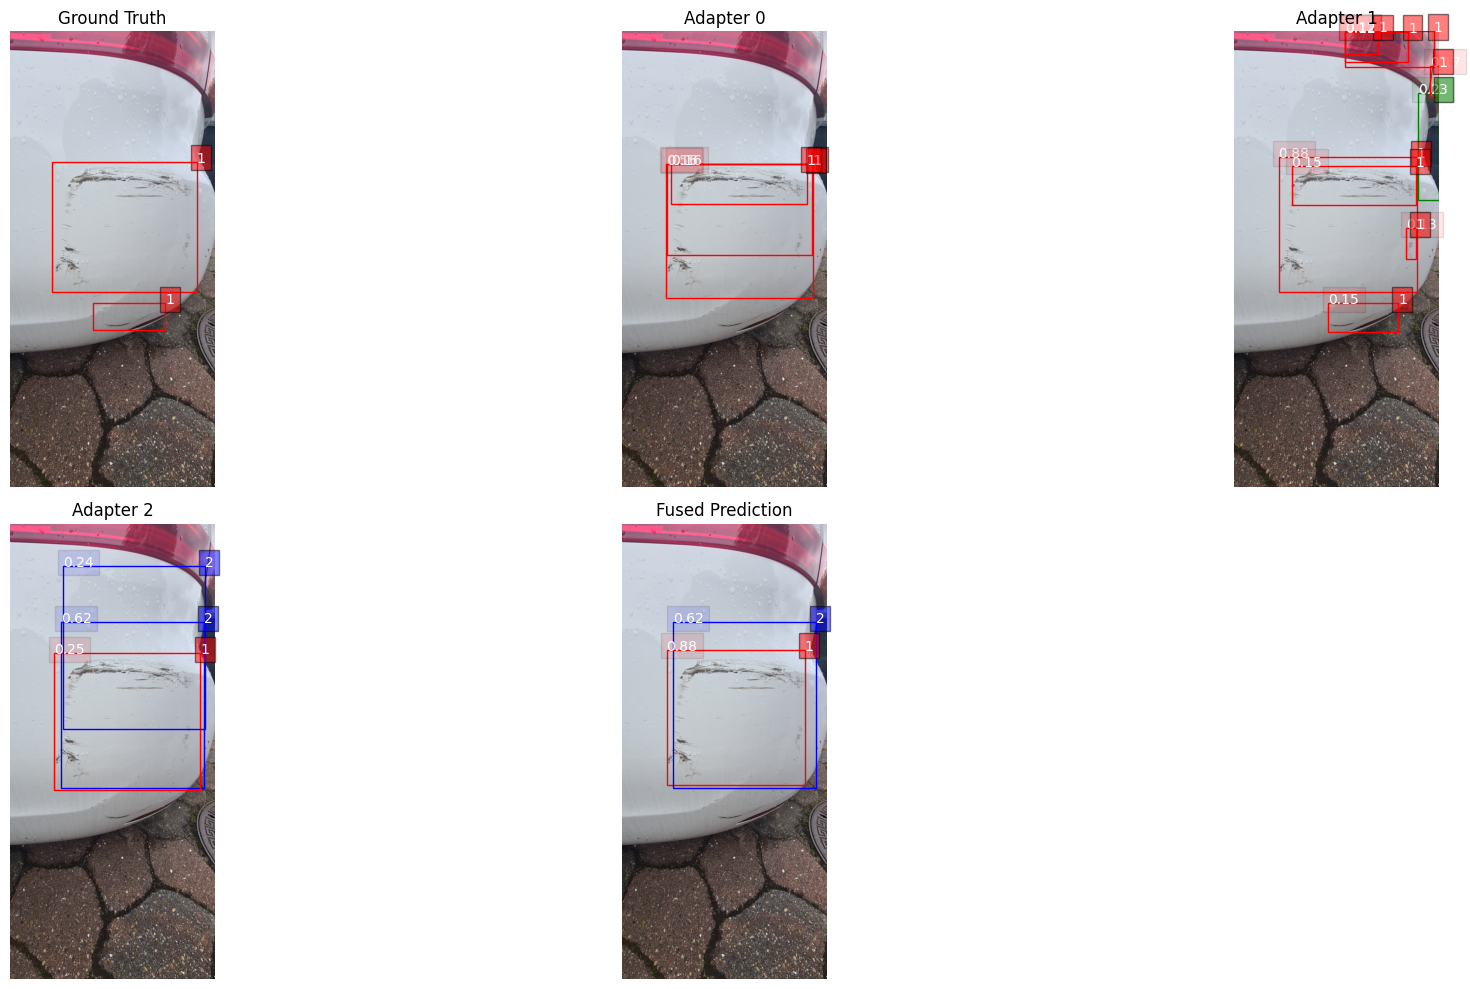

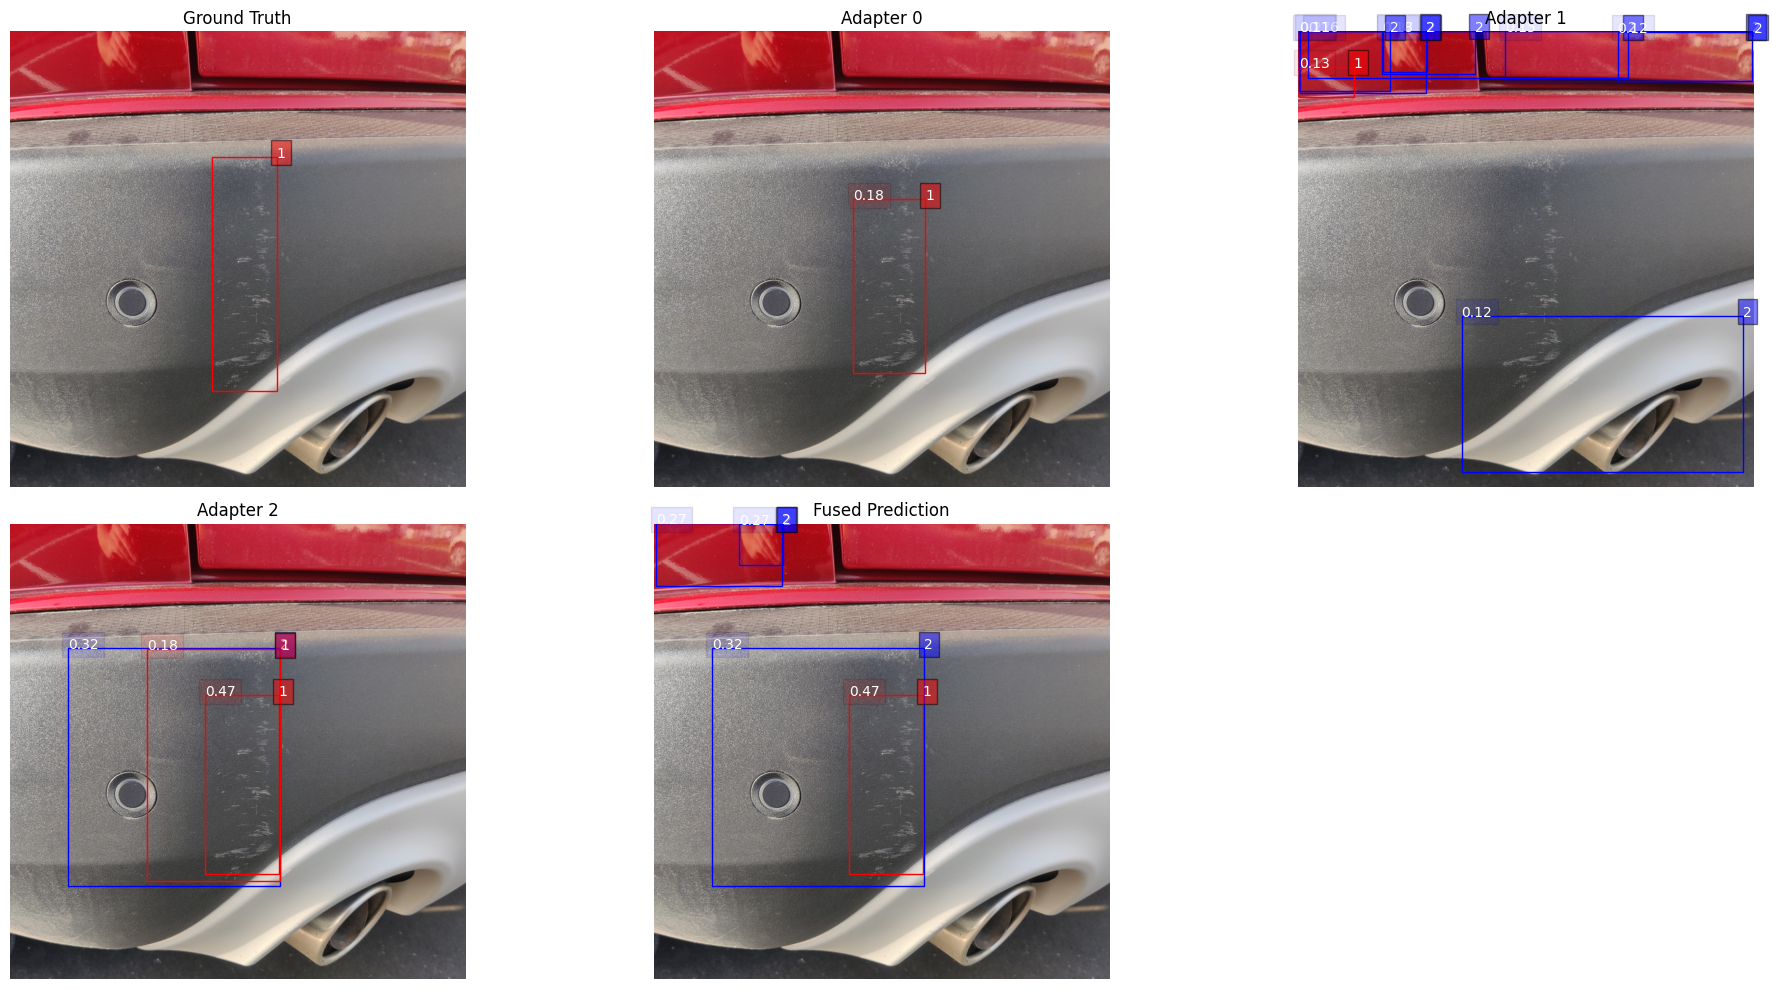

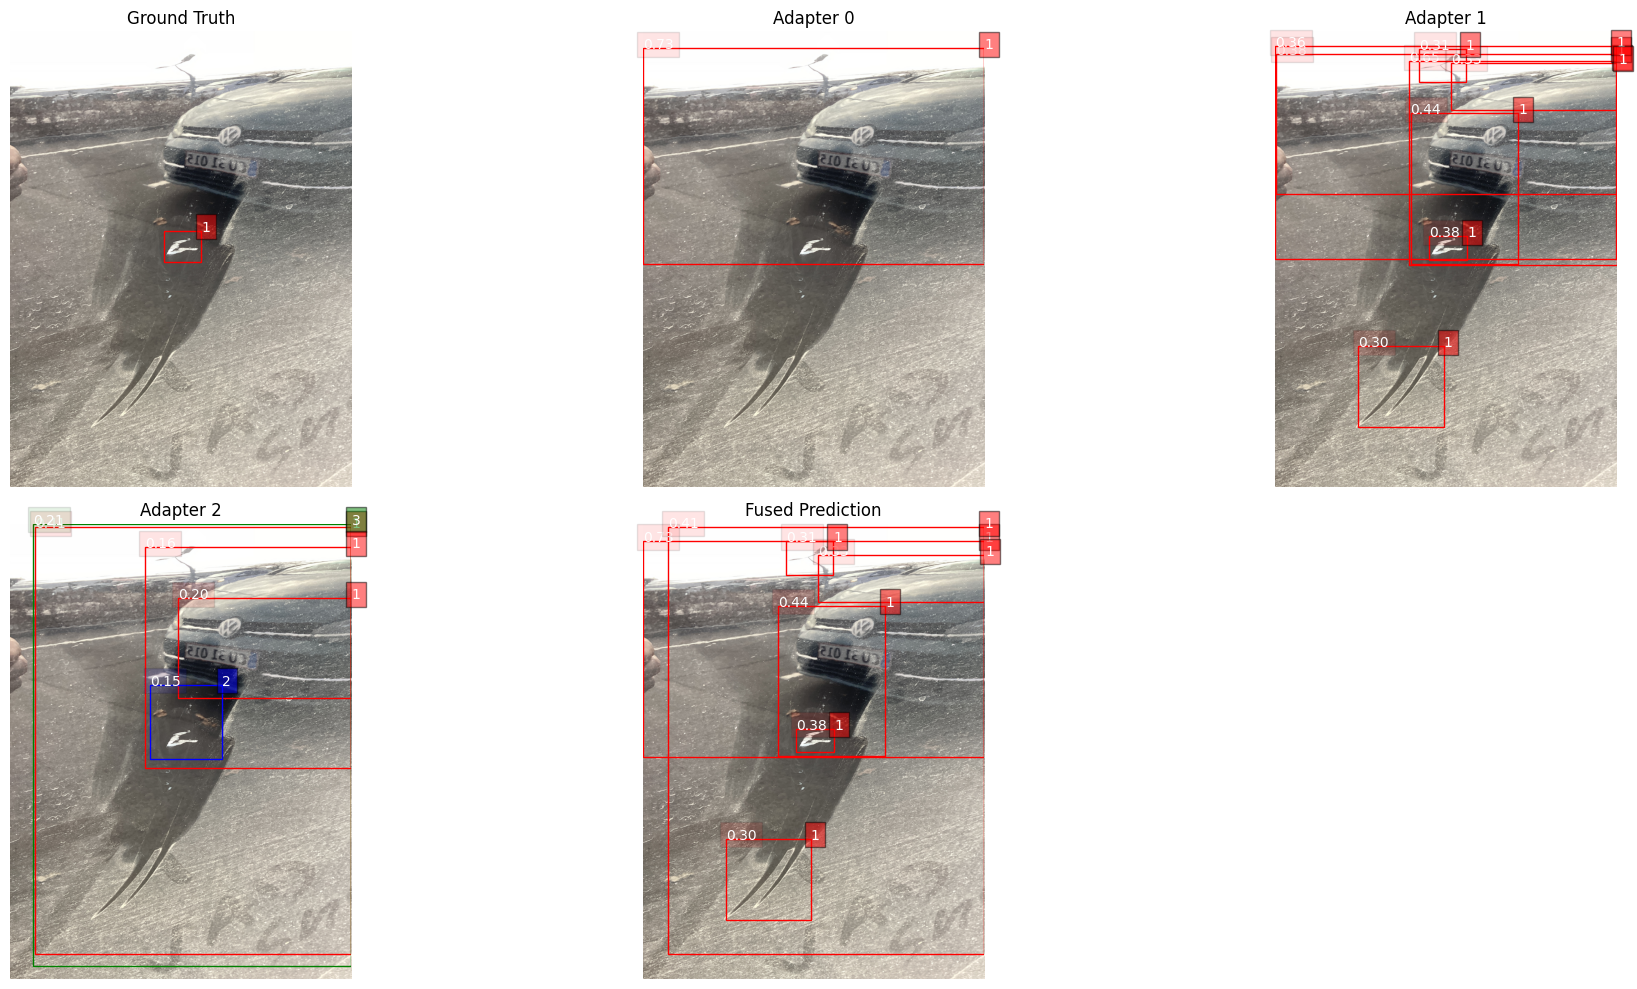

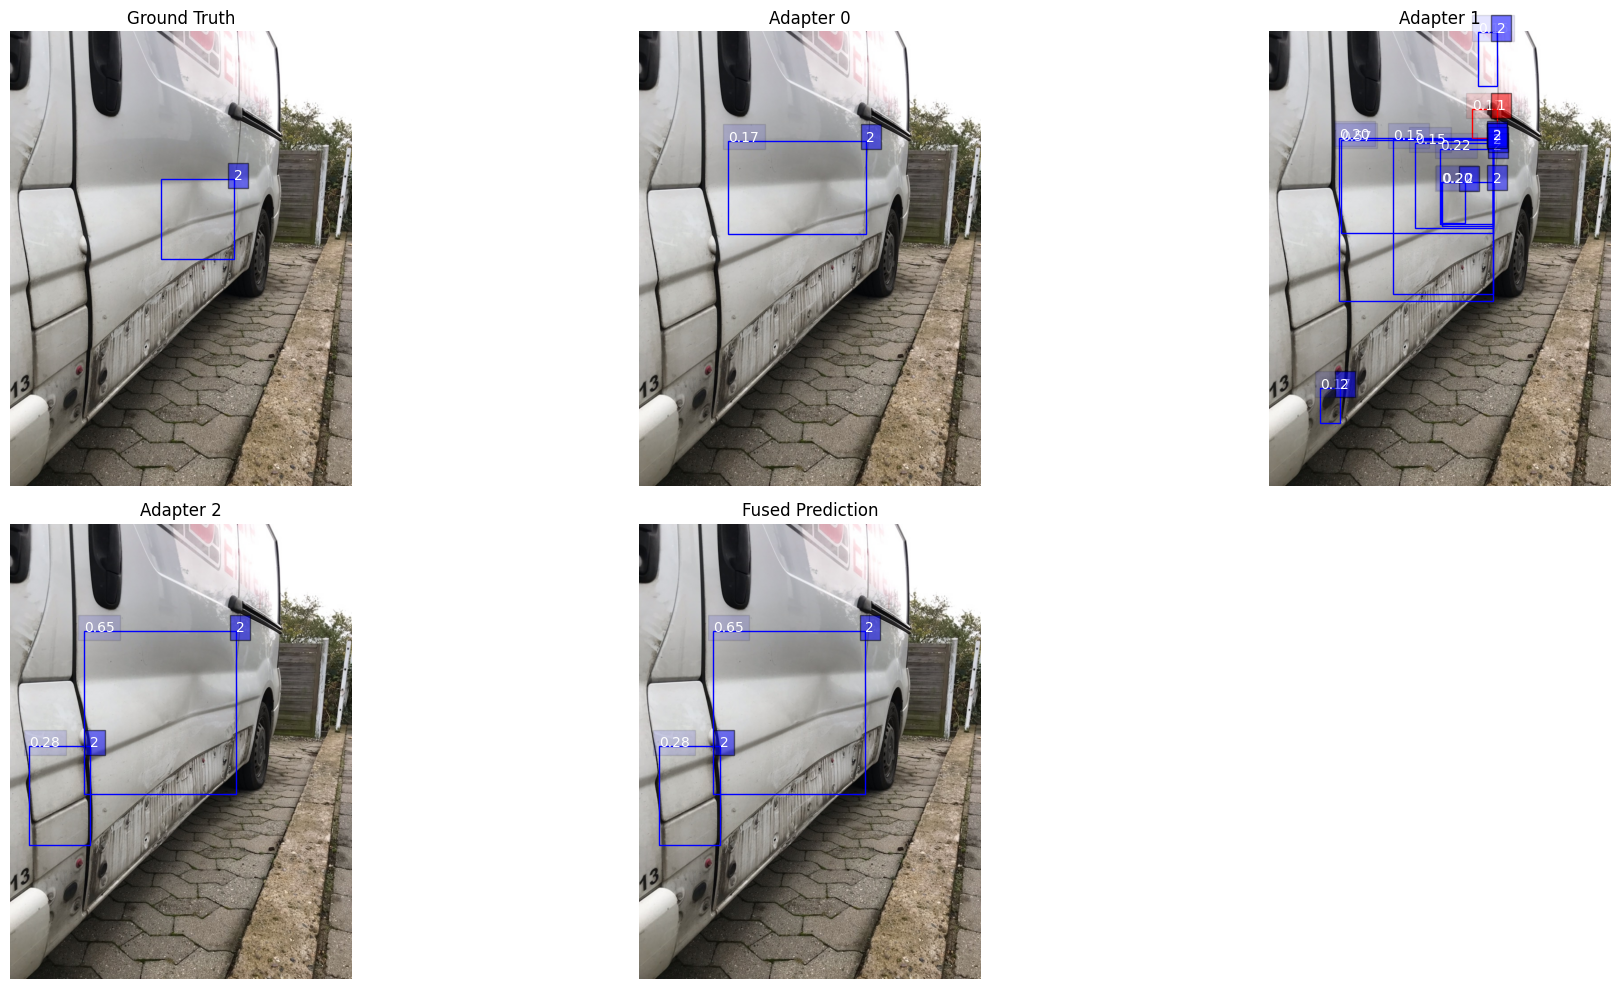

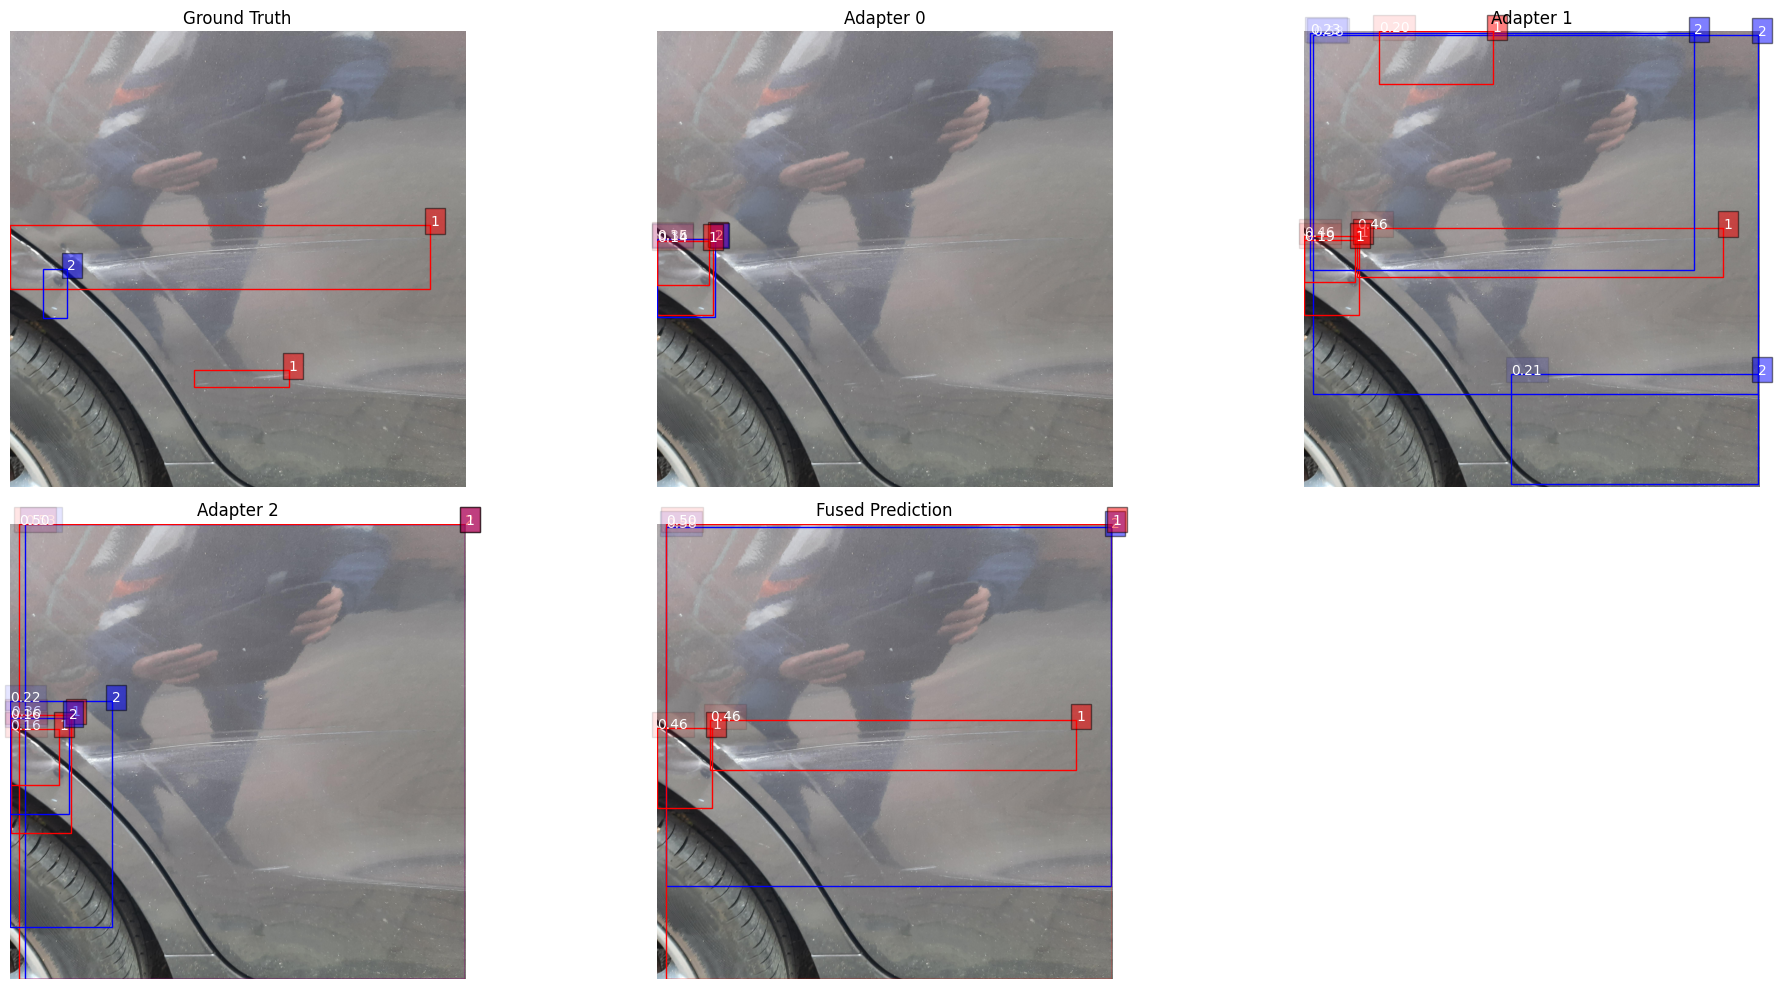

In [6]:
import random
import torch
from ml_carbucks.utils.inference import plot_img_pred_subplots as psp

def display_models(cnt, skip=0):
    """
    Build a loader and iterate over images, calling PSP with:
    - Ground truth
    - Per-adapter predictions  
    - Fused predictions
    """
    logger.info(f"Displaying {cnt} images after skipping {skip} images.")
    
    # Create clean loader just like before
    batch_size = 8
    loader = create_clean_loader(
        val_datasets, 
        shuffle=False, 
        transforms=None, 
        batch_size=batch_size
    )
    
    offset = -batch_size
    
    for images, targets in loader:
        offset += batch_size
        
        for i in range(len(images)): 
            if skip > 0:
                skip -= 1
                continue

            cnt -= 1
            if cnt < 0:
                break

            img = images[i]
            gt = targets[i]
            
            # Call PSP with [gt] + per-adapter + fused boxes/scores/labels
            psp(
                img_list=[torch.from_numpy(img).permute(2, 0, 1) for _ in range(len(per_adapter_preds) + 2)],
                bboxes_list=[
                    gt["boxes"],  # Ground truth
                    *[per_adapter_preds[adapter_idx][offset + i]["boxes"] for adapter_idx in range(len(per_adapter_preds))],  # Per-adapter predictions
                    fused_preds[offset + i]["boxes"],  # Fused prediction
                ],
                labels_list=[
                    gt["labels"],  # Ground truth
                    *[per_adapter_preds[adapter_idx][offset + i]["labels"] for adapter_idx in range(len(per_adapter_preds))],  # Per-adapter predictions
                    fused_preds[offset + i]["labels"],  # Fused prediction
                ],
                scores_list=[
                    None,  # Ground truth has no scores
                    *[per_adapter_preds[adapter_idx][offset + i]["scores"] for adapter_idx in range(len(per_adapter_preds))],  # Per-adapter predictions
                    fused_preds[offset + i]["scores"],  # Fused prediction
                ],
                descriptions=[
                    "Ground Truth",
                    *[f"Adapter {adapter_idx}" for adapter_idx in range(len(per_adapter_preds))],  # Per-adapter names
                    "Fused Prediction",
                ],
                coords="xyxy",
                figsize=(20, 10),
            )

        if cnt < 0:
            break

# Display some random images for comparison
cnt_random, skip_random = random.randint(2, 5), random.randint(0, 50)
logger.info(f"Randomly selecting {cnt_random} images, skipping {skip_random}")

display_models(cnt_random, skip_random)